# Exploring reconstruction data

Some notes.

1. Response times are not correct on stimulus/submission records and will need to be reconstructed
2. I find *no indication* that there are errors in the final submission. This leaves the weird indicator observations at position 0 to be explained, but it's clear they are not causing the board representation to be incorrect.

Some todos.

1. Count neighboring pieces at each position for each and both colors for error prediction
2. Look at distribution of errors by unique position.
3. Should probably do a more proper factor analysis rather than independent tests and regressions, but these are adequate (and clear!) enough for a first pass


## Boilerplate

Imports and data loading.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import os

from lib.util import *
from lib.exp4 import *

sns.set_style('white')
sns.set_context('talk')

% matplotlib inline

In [3]:
data_dir = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games/Data/4_rcn/Raw Data')

trained_files = get_all_filepaths('Trained')
untrained_files = get_all_filepaths('Untrained')
all_files = trained_files + untrained_files

DF = load_data(all_files)

/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Compute errors

First extract positions as numpy arrays for easier manipulation

### Error types


- **Black**: differences in black boards
- **White**: differences in white boards
- **Type I**: "false positive"; putting a piece where there was not one
- **Type II**: "false negative"; neglecting a piece where there should have been one
- **Type III**: "swap"; switching the color on a piece

In [4]:
def position_string_to_array(position_string):
    return np.array(list(position_string), dtype=int)

def series_to_array(series):
    return np.stack(series.map(position_string_to_array).values, axis=1)

bpi = series_to_array(DF['Black Position'])
bpf = series_to_array(DF['Black Position (final)'])
wpi = series_to_array(DF['White Position'])
wpf = series_to_array(DF['White Position (final)'])

black_errors = (bpf != bpi).astype(int)
white_errors = (wpf != wpi).astype(int)

type_1b = ((bpf == 1) & (bpi == 0)).astype(int).sum(axis=0)
type_1w = ((wpf == 1) & (wpi == 0)).astype(int).sum(axis=0)

type_2b = ((bpf == 0) & (bpi == 1)).astype(int).sum(axis=0)
type_2w = ((wpf == 0) & (wpi == 1)).astype(int).sum(axis=0)

type_3b = ((wpf == 1) & (bpi == 1)).astype(int).sum(axis=0)
type_3w = ((bpf == 1) & (wpi == 1)).astype(int).sum(axis=0)

DF['Num Black Pieces'] = bpi.sum(axis=0)
DF['Num White Pieces'] = wpi.sum(axis=0)
DF['Num Pieces'] = DF['Num Black Pieces'] + DF['Num White Pieces']
DF['Total Black Errors'] = black_errors.sum(axis=0)
DF['Total White Errors'] = white_errors.sum(axis=0)
DF['Total Errors'] = np.ceil((black_errors + white_errors) / 2).sum(axis=0)

DF['Type I Errors (black)'] = type_1b - type_3w
DF['Type I Errors (white)'] = type_1w - type_3b
DF['Type I Errors'] = type_1b + type_1w - type_3b - type_3w

DF['Type II Errors (black)'] = type_2b - type_3b
DF['Type II Errors (white)'] = type_2w - type_3w
DF['Type II Errors'] = type_2b + type_2w - type_3b - type_3w

DF['Type III Errors (black)'] = type_3b
DF['Type III Errors (white)'] = type_3w
DF['Type III Errors'] = type_3b + type_3w

## Questions

### Are there errors in the board representation data?

Yunqi previously had trouble with some oddities in the board construction sequences where a piece would be placed in position 0 (top left corner), but the board representation didn't change.

**Answer**: 
- No sign that there are excessive errors at position 0; not sure what Yunqi did before...
- Does *not* explain the quesitionable records. They must be utility indicators for the server/client, but I haven't found where in the code they're being produced or why they're necessary. Something to follow up on, but evidently not a real problem; those records can simply be dropped.

In [5]:
black_errors_by_location = black_errors.sum(axis=1)
white_errors_by_location = white_errors.sum(axis=1)

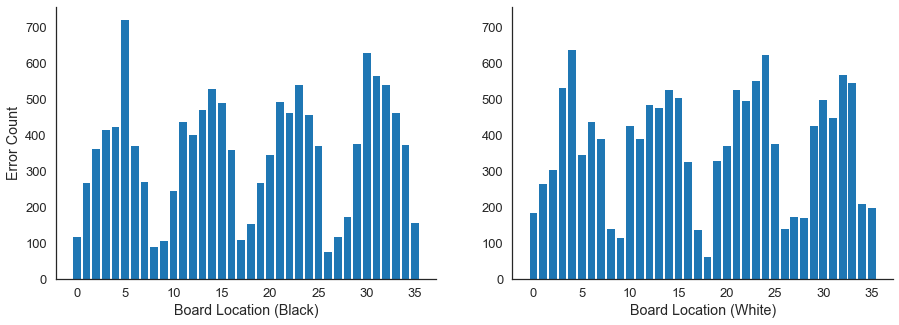

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), squeeze=False, sharex=True, sharey=True)

ax = axes[0, 0]
ax.bar(np.arange(36), black_errors_by_location)
plt.setp(ax, ylabel='Error Count', xlabel='Board Location (Black)')

ax = axes[0, 1]
ax.bar(np.arange(36), white_errors_by_location)
plt.setp(ax, xlabel='Board Location (White)')

sns.despine()

Just another very quick confirmation - there are *never* conflicts between pieces of different color in the final representation.

In [7]:
((bpf == 1) & (wpf == 1)).astype(int).sum()

0

### Are there differences in error rates between experts and non experts?

Answer: looks like yes to me, but has a complicated and significant relationship with the number of pieces. What's the correct analysis? Is this an ANOVA sort of thing for frequentists?

TODO: ELO rating effect for trained subjects?

In [13]:
piv = DF.pivot_table(index='Num Pieces', values='Total Errors', columns='Condition', margins=True, aggfunc=np.mean)
piv # just showing off pandas here

Condition,Naive,Trained,All
Num Pieces,,,
11,3.719298,3.342105,3.530702
12,4.092105,3.469298,3.780702
13,4.776316,4.478070,4.627193
14,6.456140,5.684211,6.070175
15,6.978070,6.456140,6.717105
16,7.776316,7.166667,7.471491
17,8.719298,8.328947,8.524123
18,8.627193,7.938596,8.282895
All,6.393092,5.858004,6.125548


Condition independent t-test:
 Ttest_indResult(statistic=-3.9286164111678126, pvalue=8.7018663725315566e-05) 


# Pieces vs Total Errors correlation

All: LinregressResult(slope=0.78764619883040932, intercept=-5.2953216374268992, rvalue=0.43795537927415945, pvalue=7.6052642377300263e-171, stderr=0.026776332169987354) 

Trained LinregressResult(slope=0.77751670843776111, intercept=-5.4159878863826236, rvalue=0.41734572213189186, pvalue=8.5862938917470562e-78, stderr=0.039662761303886906) 

Naive LinregressResult(slope=0.79777568922305775, intercept=-5.1746553884711801, rvalue=0.46284779209292032, pvalue=1.6611767029244807e-97, stderr=0.035794530307343191)


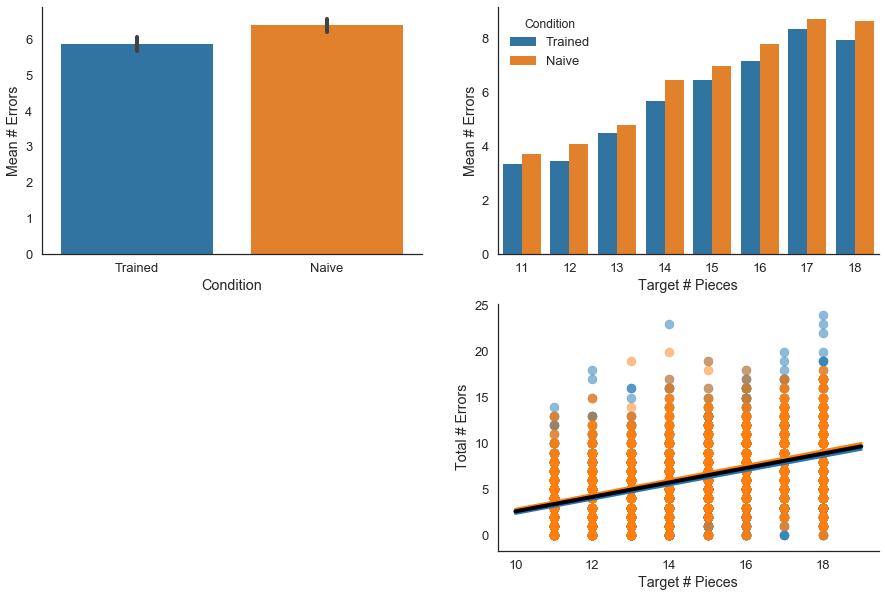

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), squeeze=False)

tr = DF.loc[DF['Condition'] == 'Trained']
na = DF.loc[DF['Condition'] == 'Naive']

ax = axes[0, 0]
sns.barplot(x='Condition', y='Total Errors', data=DF, ax=ax)
plt.setp(ax, ylabel='Mean # Errors')
ttest = sts.ttest_ind(tr['Total Errors'], na['Total Errors'])
print('Condition independent t-test:\n', ttest, '\n\n')

ax = axes[0, 1]
sns.barplot(x='Num Pieces', y='Total Errors', hue='Condition', data=DF, ax=ax, ci=None)
plt.setp(ax, xlabel='Target # Pieces', ylabel='Mean # Errors')

ax = axes[1, 1]

ax.scatter(tr['Num Pieces'], tr['Total Errors'], alpha=.5)
ax.scatter(na['Num Pieces'], na['Total Errors'], alpha=.5)
lr = sts.linregress(DF['Num Pieces'], DF['Total Errors'])
lr_tr = sts.linregress(tr['Num Pieces'], tr['Total Errors'])
lr_na = sts.linregress(na['Num Pieces'], na['Total Errors'])
print('# Pieces vs Total Errors correlation\n\nAll:', lr, '\n\nTrained', lr_tr, '\n\nNaive', lr_na)

x = np.arange(10, 20)
ax.plot(x, x * lr_tr.slope + lr_tr.intercept, linewidth=3)
ax.plot(x, x * lr_na.slope + lr_na.intercept, linewidth=3)
ax.plot(x, x * lr.slope + lr.intercept, color='black', linewidth=4)
plt.setp(ax, ylabel='Total # Errors', xlabel='Target # Pieces')

axes[1, 0].set_visible(False)

sns.despine()

### Are there different patterns for forgetting pieces, adding extras, and switching colors?

**Answer**: Yes, looks like it.

- More experienced players *may* be *slightly* more likely to add a piece where none previously existed
- More experienced players are substantially less likely to forget a piece
- More experienced players are somewhat less likely to get the color of a piece wrong

Type I Ttest:
 Ttest_indResult(statistic=2.0829104407523378, pvalue=0.037328912594820775) 

Type II Ttest:
 Ttest_indResult(statistic=-5.1225228229880369, pvalue=3.170965772659798e-07) 

Type III Ttest:
 Ttest_indResult(statistic=-3.8508961941492612, pvalue=0.00011970699502190505) 



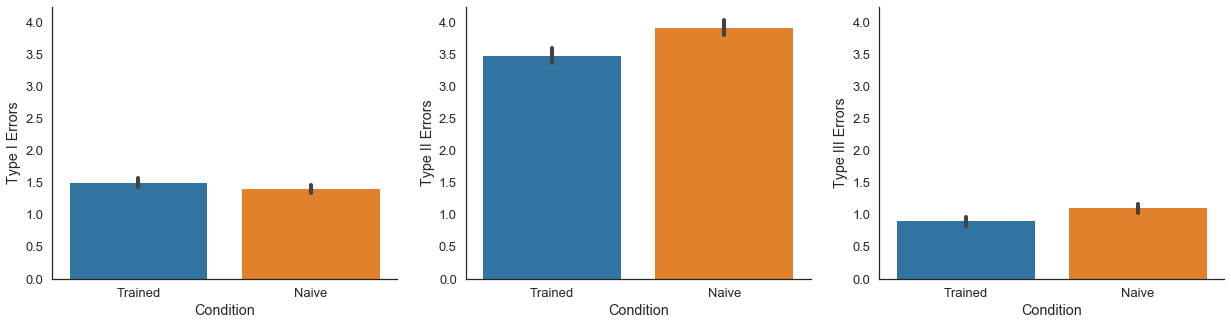

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(21, 5), squeeze=False, sharey=True)

ax = axes[0, 0]
sns.barplot(x='Condition', y='Type I Errors', data=DF, ax=ax)
ttest = sts.ttest_ind(tr['Type I Errors'], na['Type I Errors'])
print('Type I Ttest:\n', ttest, '\n')

ax = axes[0, 1]
sns.barplot(x='Condition', y='Type II Errors', data=DF, ax=ax)
ttest = sts.ttest_ind(tr['Type II Errors'], na['Type II Errors'])
print('Type II Ttest:\n', ttest, '\n')

ax = axes[0, 2]
sns.barplot(x='Condition', y='Type III Errors', data=DF, ax=ax)
ttest = sts.ttest_ind(tr['Type III Errors'], na['Type III Errors'])
print('Type III Ttest:\n', ttest, '\n')


sns.despine()

### How does error likelihood depend on location?

Bonferonni correction!!

The below could use some further clarity - looks like it has to do with distribution of stimuli as much as anything else. For example, could divide by number of times a piece is located at that position.

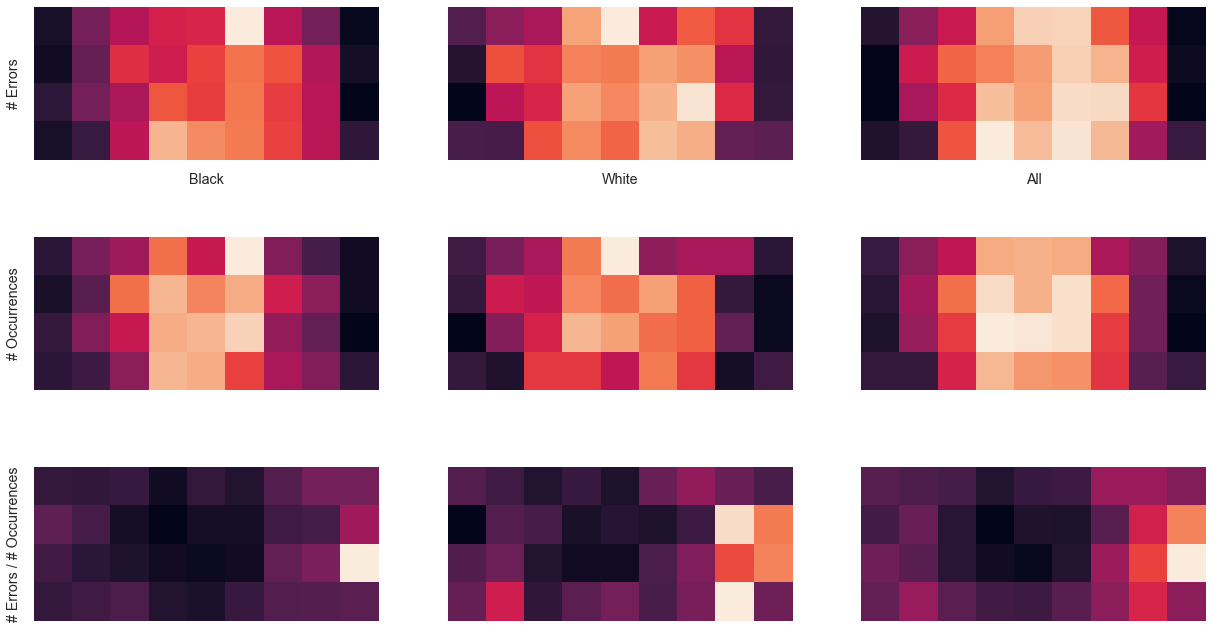

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(21, 12), squeeze=False)
heatmap_kws = {'cbar': False, 'square': True}

ax = axes[0, 0]
sns.heatmap(black_errors_by_location.reshape([4, 9]), ax=ax, cbar=False, square=True)

ax = axes[1, 0]
sns.heatmap(bpi.sum(axis=1).reshape([4, 9]), ax=ax, **heatmap_kws)

ax = axes[2, 0]
sns.heatmap((black_errors_by_location / bpi.sum(axis=1)).reshape([4, 9]), ax=ax, **heatmap_kws)

ax = axes[0, 1]
sns.heatmap(white_errors_by_location.reshape([4, 9]), ax=ax, cbar=False, square=True)

ax = axes[1, 1]
sns.heatmap(wpi.sum(axis=1).reshape([4, 9]), ax=ax, cbar=False, square=True)

ax = axes[2, 1]
sns.heatmap((white_errors_by_location / wpi.sum(axis=1)).reshape([4, 9]), ax=ax, **heatmap_kws)

ax = axes[0, 2]
sns.heatmap((black_errors_by_location + white_errors_by_location).reshape([4, 9]), ax=ax, cbar=False, square=True)

ax = axes[1, 2]
sns.heatmap((bpi + wpi).sum(axis=1).reshape([4, 9]), ax=ax, cbar=False, square=True)

ax = axes[2, 2]
sns.heatmap(
    ((black_errors_by_location + white_errors_by_location) / (bpi + wpi).sum(axis=1)).reshape([4, 9]),
    ax=ax, **heatmap_kws
)

plt.setp(axes, yticklabels=[], xticklabels=[])
    
plt.setp(axes[0, 0], ylabel='# Errors', xlabel='Black')
plt.setp(axes[0, 1], xlabel='White')
plt.setp(axes[0, 2], xlabel='All')
plt.setp(axes[1, 0], ylabel='# Occurrences')
plt.setp(axes[2, 0], ylabel='# Errors / # Occurrences')

sns.despine(left=True, bottom=True)

## Old (bad) code

Going away soon; will live on in Github's memory

In [2]:
# def reconstruct_boards(grouped):
#     """Reconstructs a trial using the move/color records"""
#     bp, wp = ('0'*36, ) * 2
    
#     new_pos = []
#     for i in grouped.index.values:
#         row = grouped.loc[i]
#         color, zet = row[['color', 'zet']]
        
#         if color == 0:
#             p = bp
#             op = wp
#         else:
#             p = wp
#             op = bp
            
#         newp = list(p)
#         newop = list(op)
        
#         if newp[zet] == '1':
#             newp[zet] = '0'
#         elif newop[zet] == '1':
#             newop[zet] = '0'
#             newp[zet] = '1'
#         else:
#             newp[zet] = '1'
            
#         if color == 0:
#             bp = ''.join(newp)
#             wp = ''.join(newop)
#         else:
#             wp = ''.join(newp)
#             bp = ''.join(newop)
            
#         new_pos.append((bp, wp))
        
#     return pd.DataFrame(new_pos, columns=['bp', 'wp'])

# def clean_reconstruction_data(filename, trained=True):
    
#     # 0: Load data, correct game index field
#     names = ['idx', 'subid', 'color', 'gi', 'mi', 'status', 'bp', 'wp', 'zet', 'rt', 'ts', 'mt', 'mx']
#     directory = 'Trained_Game' if trained else 'Untrained_Game'
#     df = pd.read_csv(os.path.join(data_dir, directory, filename), names=names)
#     df['subject'] = filename.split('_')[1][:-4]
#     df['trained'] = trained
#     reconi = df['status']=='reconi'
#     df['gi'] = np.nan
#     df.loc[reconi, 'gi'] = np.arange(len(df.loc[reconi]))
#     df['gi'] = df['gi'].fillna(method='ffill', downcast='infer')
    
    
#     # 1: Boards recorded "0" inputs wrong; reconstruct them from moves
#     reconm = df['status'] == 'recon'
#     reconf = df['status'] == 'reconf'
#     recond = df.loc[reconm].groupby('gi').apply(reconstruct_boards)
#     assembled = recond.reset_index()

#     df['bp correct'] = df['bp']
#     df['wp correct'] = df['wp']
#     df.loc[reconm, 'bp correct'] = assembled['bp'].values
#     df.loc[reconm, 'wp correct'] = assembled['wp'].values
#     df.loc[reconf, 'bp correct'] = np.nan
#     df.loc[reconf, 'wp correct'] = np.nan
#     df['bp correct'] = df['bp correct'].fillna(method='ffill')
#     df['wp correct'] = df['wp correct'].fillna(method='ffill')

#     # 2: Response times are goofed; reconstruct from timestamps
#     df['rt correct'] = df['ts'] - df['ts'].shift(1)
#     df.loc[df['status'] == 'eyecal', 'rt correct'] = df.loc[df['status'] == 'eyecal', 'rt']
    
#     # 3: Rename and drop columns (this can be combined above when done debugging)
#     df['rt'] = df['rt correct']
#     board_filter = df['status'].isin(['recon', 'reconf'])
#     df.loc[board_filter, 'bp'] = df.loc[board_filter, 'bp correct']
#     df.loc[board_filter, 'wp'] = df.loc[board_filter, 'wp correct']
#     df = df[['subject', 'trained', 'color', 'gi', 'mi', 'status', 'bp', 'wp', 'zet', 'rt', 'ts']]

#     return df

# for trained in trained_files:
#     df = clean_reconstruction_data(trained, trained=True)
#     filename = 'trained {subject}.csv'.format(subject=trained.split('_')[1][:-4])
#     df.to_csv(os.path.join(data_dir, 'Clean/Game', filename), index=False)

# for untrained in untrained_files:
#     df = clean_reconstruction_data(untrained, trained=False)
#     filename = 'untrained {subject}.csv'.format(subject=untrained.split('_')[1][:-4])
#     df.to_csv(os.path.join(data_dir, 'Clean/Game', filename), index=False)

# df = clean_reconstruction_data(untrained_files[-3], trained=False)

# idxs = df.loc[df['rt'] < 0].index.values
# idxs = pd.np.concatenate([idxs, idxs - 1])
# df.loc[idxs].sort_index()